<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">             <tr>
                <td  style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Armin Ghasemi</b><br><br>810100198</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>deep learning </b><br><br>HW_3 Q1</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Amirhossein samoudi </b><br><br>810100108</i></font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
           </tr>
        </table>
    </div>
</div>


### imports

In [2]:
import os
from google.colab import drive
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import albumentations as A
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn.functional as F
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
from copy import deepcopy
from torchinfo import summary

### mount drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path in Google Drive
drive_path = '/content/drive/MyDrive/CamVid'

# Create directory if not exists
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

# Download CamVid repository
!git clone https://github.com/lih627/CamVid.git
!cp -r /content/CamVid/* "{drive_path}/"
!rm -rf /content/CamVid

print(f"CamVid repository successfully saved to {drive_path}")

Mounted at /content/drive
Cloning into 'CamVid'...
remote: Enumerating objects: 2834, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2834 (delta 0), reused 1 (delta 0), pack-reused 2831 (from 1)
Receiving objects: 100% (2834/2834), 595.30 MiB | 16.25 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (2815/2815), done.
CamVid repository successfully saved to /content/drive/MyDrive/CamVid


### Data set preparation

Training samples: 367
Validation samples: 101
Test samples: 233

Sample training entries:
CamVid_RGB/0001TP_006690.png CamVidGray/0001TP_006690_L.png
CamVid_RGB/0001TP_006720.png CamVidGray/0001TP_006720_L.png
CamVid_RGB/0001TP_006750.png CamVidGray/0001TP_006750_L.png
CamVid_RGB/0001TP_006780.png CamVidGray/0001TP_006780_L.png
CamVid_RGB/0001TP_006810.png CamVidGray/0001TP_006810_L.png


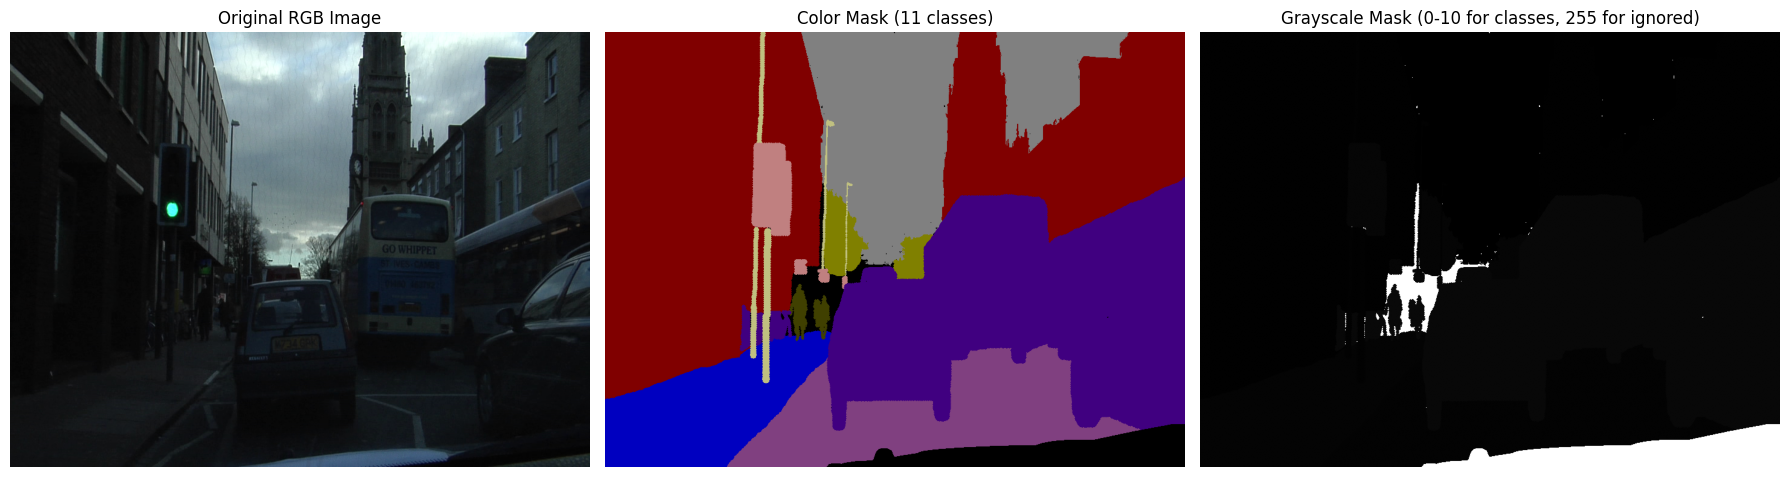


RGB image dimensions: (720, 960, 3)
Color mask dimensions: (720, 960, 3)
Grayscale mask dimensions: (960, 720)


In [ ]:
# Path to split files
base_path = '/content/drive/MyDrive/CamVid'
train_file = os.path.join(base_path, 'camvid_train.txt')
val_file = os.path.join(base_path, 'camvid_val.txt')
test_file = os.path.join(base_path, 'camvid_test.txt')

def count_samples(file_path):
    """Count number of samples in file"""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return len(lines)

# Show sample counts
print(f"Training samples: {count_samples(train_file)}")
print(f"Validation samples: {count_samples(val_file)}")
print(f"Test samples: {count_samples(test_file)}")

# Show first few training samples
with open(train_file, 'r') as f:
    print("\nSample training entries:")
    for i in range(5):
        print(f.readline().strip())



# Sample paths
rgb_path = os.path.join(base_path, 'CamVid_RGB/0001TP_006690.png')
color_label_path = os.path.join(base_path, 'CamVidColor11/0001TP_006690_L.png')
gray_label_path = os.path.join(base_path, 'CamVidGray/0001TP_006690_L.png')

# Read images
rgb_img = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
color_label = cv2.cvtColor(cv2.imread(color_label_path), cv2.COLOR_BGR2RGB)
gray_label = Image.open(gray_label_path)

# Display results
plt.figure(figsize=(18, 12))

plt.subplot(1, 3, 1)
plt.imshow(rgb_img)
plt.title('Original RGB Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(color_label)
plt.title('Color Mask (11 classes)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gray_label, cmap='gray', vmin=0, vmax=255)
plt.title('Grayscale Mask (0-10 for classes, 255 for ignored)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print dimensions
print(f"\nRGB image dimensions: {rgb_img.shape}")
print(f"Color mask dimensions: {color_label.shape}")
print(f"Grayscale mask dimensions: {gray_label.size}")

In [ ]:
# 1. Mount and setup paths
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/CamVid'
output_path = '/content/drive/MyDrive/Augmented_CamVid'

os.makedirs(os.path.join(output_path, 'CamVid_RGB'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'CamVidGray'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'CamVidColor11'), exist_ok=True)

# 2. Define transformations
spatial_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, border_mode=cv2.BORDER_REFLECT101, p=0.5),
    A.CenterCrop(height=720, width=960, p=1.0)
], additional_targets={
    'gray_mask': 'mask',
    'color_mask': 'image'
})

intensity_aug = A.Compose([
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2)
])

# 3. Load triplet function
def load_image_triplet(img_path, gray_path, color_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"RGB image not found: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray_mask = np.array(Image.open(gray_path))
    if gray_mask.ndim == 3:
        gray_mask = gray_mask[:, :, 0]

    color_mask = cv2.imread(color_path)
    if color_mask is None:
        raise FileNotFoundError(f"Color mask not found: {color_path}")
    color_mask = cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB)

    return img, gray_mask, color_mask

# 4. Augment and save
def augment_and_save(img_path, gray_path, color_path, aug_num):
    try:
        img, gray_mask, color_mask = load_image_triplet(img_path, gray_path, color_path)

        # Apply spatial transform to all
        augmented = spatial_aug(
            image=img,
            gray_mask=gray_mask,
            color_mask=color_mask
        )

        aug_img = augmented['image']
        aug_gray_mask = augmented['gray_mask']
        aug_color_mask = augmented['color_mask']

        # Apply intensity transform only to image
        aug_img = intensity_aug(image=aug_img)['image']

        # Make sure masks are uint8
        aug_gray_mask = np.array(aug_gray_mask).astype(np.uint8)

        # Save paths
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        rgb_save = os.path.join(output_path, 'CamVid_RGB', f"{base_name}_aug{aug_num}.png")
        gray_save = os.path.join(output_path, 'CamVidGray', f"{base_name}_aug{aug_num}_L.png")
        color_save = os.path.join(output_path, 'CamVidColor11', f"{base_name}_aug{aug_num}_L.png")

        # Save files
        cv2.imwrite(rgb_save, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
        Image.fromarray(aug_gray_mask).save(gray_save)
        cv2.imwrite(color_save, cv2.cvtColor(aug_color_mask, cv2.COLOR_RGB2BGR))

        return rgb_save, gray_save, color_save
    except Exception as e:
        print(f"Error augmenting {img_path}: {e}")
        return None, None, None

# 5. Process dataset and create splits
def process_dataset():
    rgb_images = sorted(glob(os.path.join(base_path, 'CamVid_RGB', '*.png')))
    all_triplets = []

    for img_path in rgb_images:
        name = os.path.splitext(os.path.basename(img_path))[0]
        gray_path = os.path.join(base_path, 'CamVidGray', f'{name}_L.png')
        color_path = os.path.join(base_path, 'CamVidColor11', f'{name}_L.png')

        if os.path.exists(gray_path) and os.path.exists(color_path):
            all_triplets.append((img_path, gray_path, color_path))
        else:
            print(f"Missing mask for: {img_path}")

    # Split
    train, test_val = train_test_split(all_triplets, test_size=0.3, random_state=42)
    val, test = train_test_split(test_val, test_size=0.5, random_state=42)

    for split_name, split_data in [('train', train), ('val', val), ('test', test)]:
        split_lines = []

        for img, gray, color in split_data:
            rel_name = os.path.relpath(img, base_path)
            split_lines.append(rel_name)

            for i in range(1, 4):
                aug_rgb, _, _ = augment_and_save(img, gray, color, i)
                if aug_rgb:
                    rel_aug_name = os.path.relpath(aug_rgb, base_path)
                    split_lines.append(rel_aug_name)

        with open(os.path.join(output_path, f'aug_{split_name}.txt'), 'w') as f:
            f.write('\n'.join(split_lines))

        print(f"{split_name} split saved with {len(split_lines)} samples")

# 6. Count statistics
def count_augmented_data():
    original = glob(os.path.join(base_path, 'CamVid_RGB', '*.png'))
    augmented = glob(os.path.join(output_path, 'CamVid_RGB', '*_aug*.png'))
    gray_masks = glob(os.path.join(output_path, 'CamVidGray', '*_aug*.png'))
    color_masks = glob(os.path.join(output_path, 'CamVidColor11', '*_aug*.png'))

    print("\n--- Dataset Summary ---")
    print(f"Original images: {len(original)}")
    print(f"Augmented images: {len(augmented)}")
    print(f"Grayscale masks (aug): {len(gray_masks)}")
    print(f"Color masks (aug): {len(color_masks)}")
    print("------------------------")

# 7. Run everything
print("Running augmentation process...")
process_dataset()
count_augmented_data()
print("Done.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running augmentation process...
train split saved with 1960 samples
val split saved with 420 samples
test split saved with 424 samples

--- Dataset Summary ---
Original images: 701
Augmented images: 2103
Grayscale masks (aug): 2103
Color masks (aug): 2103
------------------------
Done.


In [ ]:
def merge_dirs(source_dirs, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for src in source_dirs:
        for fname in os.listdir(src):
            src_path = os.path.join(src, fname)
            dst_path = os.path.join(target_dir, fname)
            if not os.path.exists(dst_path):
                shutil.copy2(src_path, dst_path)


main_dir = '/content/drive/MyDrive/CamVid'
aug_dir = '/content/drive/MyDrive/Augmented_CamVid'
combined_dir = '/content/drive/MyDrive/CamVid_Combined'


merge_dirs([os.path.join(main_dir, 'CamVid_RGB'), os.path.join(aug_dir, 'CamVid_RGB')],
           os.path.join(combined_dir, 'CamVid_RGB'))

merge_dirs([os.path.join(main_dir, 'CamVidColor11'), os.path.join(aug_dir, 'CamVidColor11')],
           os.path.join(combined_dir, 'CamVidColor11'))

merge_dirs([os.path.join(main_dir, 'CamVidGray'), os.path.join(aug_dir, 'CamVidGray')],
           os.path.join(combined_dir, 'CamVidGray'))


In [ ]:
# Define directories
base_dir = '/content/drive/MyDrive/CamVid_Combined'
rgb_dir = os.path.join(base_dir, 'CamVid_RGB')
color_label_dir = os.path.join(base_dir, 'CamVidColor11')
gray_label_dir = os.path.join(base_dir, 'CamVidGray')

# Collect all image filenames
all_images = [f for f in os.listdir(rgb_dir) if f.endswith('.png')]

# Separate original and augmented images
original_images = [f for f in all_images if '_aug' not in f]
augmented_images = [f for f in all_images if '_aug' in f]

# Prepare report containers
missing_color_labels = []
missing_gray_labels = []
incomplete_augmentations = []

# Process each original image
for orig_img in original_images:
    base_name = orig_img[:-4]  # remove '.png'

    # Check color label
    color_label = f"{base_name}_L.png"
    if not os.path.exists(os.path.join(color_label_dir, color_label)):
        missing_color_labels.append(color_label)

    # Check grayscale label
    gray_label = f"{base_name}_L.png"
    if not os.path.exists(os.path.join(gray_label_dir, gray_label)):
        missing_gray_labels.append(gray_label)

    # Check 3 augmented versions
    missing_augs = []
    for i in range(1, 4):
        aug_image = f"{base_name}_aug{i}.png"
        aug_color_label = f"{base_name}_aug{i}_L.png"
        aug_gray_label = f"{base_name}_aug{i}_L.png"

        if not os.path.exists(os.path.join(rgb_dir, aug_image)):
            missing_augs.append(aug_image)
        if not os.path.exists(os.path.join(color_label_dir, aug_color_label)):
            missing_color_labels.append(aug_color_label)
        if not os.path.exists(os.path.join(gray_label_dir, aug_gray_label)):
            missing_gray_labels.append(aug_gray_label)

    if missing_augs:
        incomplete_augmentations.append((orig_img, missing_augs))

# Final report
print("📊 Final Report")
print(f"Total RGB images: {len(all_images)}")
print(f"Original images: {len(original_images)}")
print(f"Augmented images: {len(augmented_images)}")

print("\n❌ Missing color labels:")
for item in missing_color_labels:
    print("-", item)

print("\n❌ Missing grayscale labels:")
for item in missing_gray_labels:
    print("-", item)

print("\n❌ Incomplete augmentations:")
for orig, missing in incomplete_augmentations:
    print(f"- {orig} is missing: {missing}")

📊 Final Report
Total RGB images: 2804
Original images: 701
Augmented images: 2103

❌ Missing color labels:

❌ Missing grayscale labels:

❌ Incomplete augmentations:


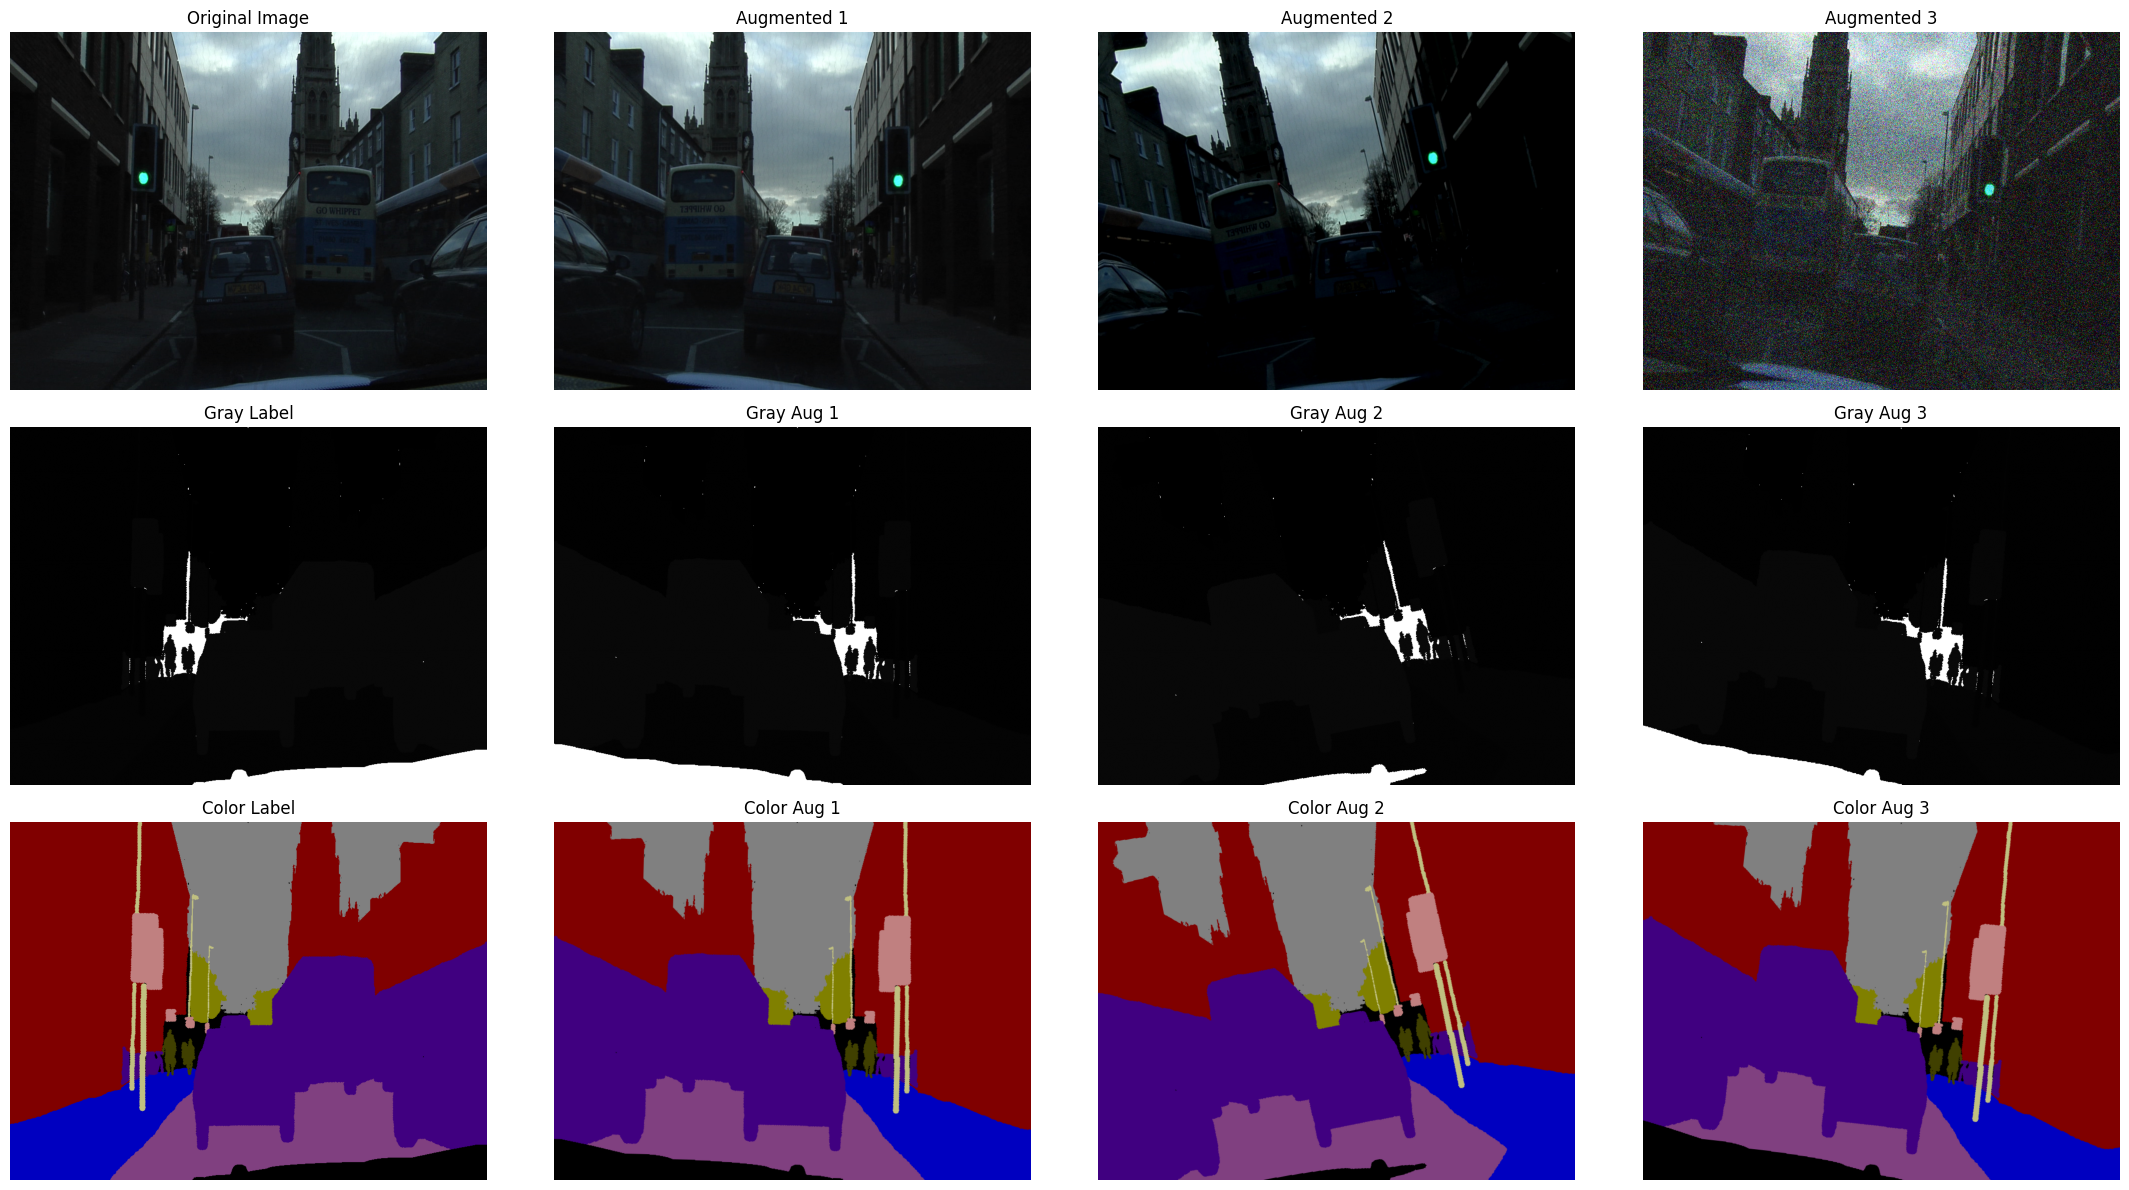

In [ ]:
base_dir = '/content/drive/MyDrive/CamVid_Combined'
img_dir = os.path.join(base_dir, 'CamVid_RGB')
gray_label_dir = os.path.join(base_dir, 'CamVidGray')
color_label_dir = os.path.join(base_dir, 'CamVidColor11')

# Choose a base name that has augmentations
base_name = '0001TP_006690'

# Image paths
img_path = os.path.join(img_dir, f'{base_name}.png')
aug_paths = [os.path.join(img_dir, f'{base_name}_aug{i}.png') for i in range(1, 4)]

# Grayscale label paths
gray_labels = [os.path.join(gray_label_dir, f'{base_name}_L.png')] + \
              [os.path.join(gray_label_dir, f'{base_name}_aug{i}_L.png') for i in range(1, 4)]

# Color label paths
color_labels = [os.path.join(color_label_dir, f'{base_name}_L.png')] + \
               [os.path.join(color_label_dir, f'{base_name}_aug{i}_L.png') for i in range(1, 4)]

# Create 3 rows: RGB images, grayscale labels, color labels
fig, axs = plt.subplots(3, 4, figsize=(22, 12))

# Row 1: RGB images
axs[0, 0].imshow(Image.open(img_path))
axs[0, 0].set_title('Original Image')

for i, path in enumerate(aug_paths):
    axs[0, i+1].imshow(Image.open(path))
    axs[0, i+1].set_title(f'Augmented {i+1}')

# Row 2: Grayscale labels (with cmap='gray')
for i, path in enumerate(gray_labels):
    axs[1, i].imshow(Image.open(path), cmap='gray')
    axs[1, i].set_title('Gray Label' if i == 0 else f'Gray Aug {i}')

# Row 3: Color labels
for i, path in enumerate(color_labels):
    axs[2, i].imshow(Image.open(path))
    axs[2, i].set_title('Color Label' if i == 0 else f'Color Aug {i}')

# Turn off axes
for ax in axs.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
input_dir = '/content/drive/MyDrive/CamVid'
combined_dir = '/content/drive/MyDrive/CamVid_Combined'
output_dir = '/content/drive/MyDrive/CamVid_Combined'

os.makedirs(output_dir, exist_ok=True)

splits = ['camvid_train.txt', 'camvid_val.txt', 'camvid_test.txt', 'camvid_trainval.txt']
missing_files = []

def check_file_exists_in_combined(rel_path):
    full_path = os.path.join(combined_dir, rel_path)
    if not os.path.exists(full_path):
        missing_files.append(rel_path)
        return False
    return True

for split in splits:
    input_path = os.path.join(input_dir, split)
    output_path = os.path.join(output_dir, f'aug_{split}')

    with open(input_path, 'r') as f:
        lines = f.read().strip().split('\n')

    new_lines = []

    for line in lines:
        rgb_rel, gray_rel = line.strip().split()

        if check_file_exists_in_combined(rgb_rel) and check_file_exists_in_combined(gray_rel):
            new_lines.append(f"{rgb_rel} {gray_rel}")
            base_name = os.path.splitext(os.path.basename(rgb_rel))[0]

            for i in range(1, 4):
              # RGB augmentation
              aug_rgb = rgb_rel.replace('.png', f'_aug{i}.png')

              # Grayscale mask augmentation
              base_gray = os.path.basename(gray_rel)
              name_wo_ext = os.path.splitext(base_gray)[0]
              name_wo_L = name_wo_ext.replace('_L', '')
              aug_gray_name = f'{name_wo_L}_aug{i}_L.png'
              aug_gray = os.path.join(os.path.dirname(gray_rel), aug_gray_name)

              if check_file_exists_in_combined(aug_rgb) and check_file_exists_in_combined(aug_gray):
                  new_lines.append(f"{aug_rgb} {aug_gray}")


    with open(output_path, 'w') as f:
        f.write('\n'.join(new_lines))

    print(f"✅ Done: {output_path} ({len(new_lines)} lines)")

# Report
if missing_files:
    print("\n⚠️ Missing files:")
    for f in missing_files:
        print(f"- {f}")
else:
    print("\n✅ All files found in CamVid_Combined.")


✅ Done: /content/drive/MyDrive/CamVid_Combined/aug_camvid_train.txt (1468 lines)
✅ Done: /content/drive/MyDrive/CamVid_Combined/aug_camvid_val.txt (404 lines)
✅ Done: /content/drive/MyDrive/CamVid_Combined/aug_camvid_test.txt (932 lines)
✅ Done: /content/drive/MyDrive/CamVid_Combined/aug_camvid_trainval.txt (1872 lines)

✅ All files found in CamVid_Combined.


### Optimizer, metrics and loss function

In [4]:
def dice_coefficient(pred, target, eps=1e-6):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + eps) / (pred.sum() + target.sum() + eps)

def iou_score(pred, target, num_classes):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    cm = confusion_matrix(target.cpu().numpy(), pred.cpu().numpy(), labels=list(range(num_classes)))
    intersection = np.diag(cm)
    union = cm.sum(1) + cm.sum(0) - intersection
    iou = intersection / (union + 1e-6)
    return np.nanmean(iou)

### Implementation of the model

In [9]:
class DSConv(nn.Module):
    def __init__(self, in_ch, out_ch, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=stride, padding=1, groups=in_ch, bias=False),  # depthwise
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),  # pointwise
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class LearningToDownsample(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DSConv(32, 48, stride=2),  # Depthwise Separable
            DSConv(48, 64, stride=2),  # Depthwise Separable
        )

    def forward(self, x):
        return self.conv(x)

class InvertedResidual(nn.Module):
    def __init__(self, in_ch, out_ch, stride, expand_ratio):
        super().__init__()
        hidden_dim = in_ch * expand_ratio
        self.use_res_connect = stride == 1 and in_ch == out_ch

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1,
                      groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Conv2d(hidden_dim, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, out_channels, pool_sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=ps),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for ps in pool_sizes
        ])
        self.bottleneck = nn.Conv2d(in_channels + len(pool_sizes) * out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        h, w = x.size(2), x.size(3)
        pyramids = [x]
        for stage in self.stages:
            pooled = stage(x)
            upsampled = F.interpolate(pooled, size=(h, w), mode='bilinear', align_corners=True)
            pyramids.append(upsampled)
        out = torch.cat(pyramids, dim=1)
        out = self.bottleneck(out)
        return out

class GlobalFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.bottlenecks = nn.Sequential(
            InvertedResidual(64, 64, stride=2, expand_ratio=6),
            InvertedResidual(64, 96, stride=2, expand_ratio=6),
            InvertedResidual(96, 128, stride=1, expand_ratio=6),
        )

        self.ppm = PyramidPoolingModule(in_channels=128, out_channels=128, pool_sizes=(1, 2, 3, 6))

    def forward(self, x):
        x = self.bottlenecks(x)
        x = self.ppm(x)
        return x



class FeatureFusionModule(nn.Module):
    def __init__(self, high_ch, low_ch, out_ch):
        super().__init__()
        self.low_dconv = nn.Sequential(
            nn.Conv2d(low_ch, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
        )
        self.high_dconv = nn.Sequential(
            nn.Conv2d(high_ch, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, high_feat, low_feat):
        low_feat = self.low_dconv(low_feat)
        low_feat = F.interpolate(low_feat, size=high_feat.size()[2:], mode='bilinear', align_corners=True)
        high_feat = self.high_dconv(high_feat)
        return self.relu(high_feat + low_feat)


class Classifier(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1, groups=in_ch, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_ch, in_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_ch, num_classes, kernel_size=1)
        )

    def forward(self, x):
        return self.conv(x)


class FastSCNN(nn.Module):
    def __init__(self, num_classes=19):
        super().__init__()
        self.downsample = LearningToDownsample()
        self.global_features = GlobalFeatureExtractor()
        self.fusion = FeatureFusionModule(high_ch=64, low_ch=128, out_ch=128)
        self.classifier = Classifier(128, num_classes)

    def forward(self, x):
        high_res = self.downsample(x)
        low_res = self.global_features(high_res)
        fused = self.fusion(high_res, low_res)
        out = self.classifier(fused)
        out = F.interpolate(out, size=x.size()[2:], mode='bilinear', align_corners=True)
        return out



### Model training

In [6]:
class CamVidDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        with open(txt_file, 'r') as f:
            self.image_mask_pairs = [line.strip().split() for line in f.readlines()]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_mask_pairs[idx][0])
        mask_path = os.path.join(self.root_dir, self.image_mask_pairs[idx][1])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


from torch.utils.data import DataLoader

def get_loaders(root, txt_train, txt_val, txt_test, batch_size, image_size=(360, 480)):
    train_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize(image_size, interpolation=Image.NEAREST),
        transforms.PILToTensor()
    ])

    train_dataset = CamVidDataset(txt_file=txt_train, root_dir=root,
                                  transform=train_transform, target_transform=mask_transform)

    val_dataset = CamVidDataset(txt_file=txt_val, root_dir=root,
                                transform=train_transform, target_transform=mask_transform)

    test_dataset = CamVidDataset(txt_file=txt_test, root_dir=root,
                                 transform=train_transform, target_transform=mask_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=2, pin_memory=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2, pin_memory=True)

    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader, test_dataset



In [10]:
def train_model(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=100,
    batch_size=32,
    num_classes=11,
    optimizer_type='sgd',          # 'sgd' or 'adam'
    criterion_type='crossentropy', # 'crossentropy' or 'dice'
    init_lr=0.045,
    early_stopping_patience=10,
    model_save_path='best_model.pth'
):
    print(f"\nTraining on device: {device}\n")
    history = {
      'loss': [],
      'iou': [],
      'dice': [],
      'accuracy': []
    }
    if criterion_type == 'crossentropy':
        criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
    elif criterion_type == 'dice':
        criterion = lambda pred, target: 1 - dice_coefficient(torch.argmax(pred, dim=1).float(), target.float())
    else:
        raise ValueError("Unsupported loss type")

    if optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=4e-5)
    elif optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
    else:
        raise ValueError("Unsupported optimizer type")

    model = model.to(device)
    best_iou = 0.0
    patience_counter = 0
    total_iters = len(train_loader) * num_epochs

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (images, masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images = images.to(device)
            masks = masks.squeeze(1).long().to(device)

            iter = epoch * len(train_loader) + i
            lr = init_lr * (1 - iter / total_iters) ** 0.9
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        # === Validation ===
        model.eval()
        total_iou, total_dice = 0.0, 0.0
        correct_pixels, total_pixels = 0, 0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.squeeze(1).long().to(device)

                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)

                total_iou += iou_score(preds, masks, num_classes)
                total_dice += dice_coefficient(preds.float(), masks.float())

                valid = (masks != 255)
                correct_pixels += ((preds == masks) & valid).sum().item()
                total_pixels += valid.sum().item()

        avg_iou = total_iou / len(val_loader)
        avg_dice = total_dice / len(val_loader)
        accuracy = correct_pixels / total_pixels if total_pixels > 0 else 0

        print(f"📊 [Epoch {epoch+1}] Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | Dice: {avg_dice:.4f} | Acc: {accuracy*100:.2f}%")
        history['loss'].append(avg_loss)
        history['iou'].append(avg_iou)
        history['dice'].append(avg_dice)
        history['accuracy'].append(accuracy)

        # === Early Stopping ===
        if avg_iou > best_iou:
            print(f"✔️ New best IoU: {avg_iou:.4f} (model saved)")
            best_iou = avg_iou
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement. EarlyStopping counter: {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered. Best IoU: {best_iou:.4f}")
                break
    return history


In [11]:
root_dir = '/content/drive/MyDrive/CamVid_Combined'
train_txt = os.path.join(root_dir, 'aug_camvid_train.txt')
val_txt = os.path.join(root_dir, 'aug_camvid_val.txt')
test_txt = os.path.join(root_dir, 'aug_camvid_test.txt')

batch_size = 32
num_epochs = 100
num_classes = 11
init_lr_adam = 0.01
init_lr_sgd = 0.005
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader, val_loader, test_loader, test_dataset = get_loaders(
    root=root_dir,
    txt_train=train_txt,
    txt_val=val_txt,
    txt_test=test_txt,
    batch_size=8,
    image_size=(360, 480)
)

model = FastSCNN(num_classes=num_classes)
model_sgd = deepcopy(model)
model_adam = deepcopy(model)

print(f"\nTraining with adam:\n")
adam_history = train_model(
    model=model_adam,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=100,
    batch_size=8,
    num_classes=11,
    optimizer_type='adam',
    criterion_type='crossentropy',
    init_lr=init_lr_adam,
    early_stopping_patience=10,
    model_save_path='/content/drive/MyDrive/best_model_adam.pth'
)

print(f"\nTraining with sgd:\n")
sgd_history = train_model(
    model=model_sgd,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=100,
    batch_size=8,
    num_classes=11,
    optimizer_type='sgd',
    criterion_type='crossentropy',
    init_lr=init_lr_sgd,
    early_stopping_patience=10,
    model_save_path='/content/drive/MyDrive/best_model_sgd.pth'
)



Training with adam:


Training on device: cuda



Epoch 1/100: 100%|██████████| 184/184 [00:48<00:00,  3.77it/s]


📊 [Epoch 1] Loss: 0.7038 | IoU: 0.2481 | Dice: 2.5568 | Acc: 65.77%
✔️ New best IoU: 0.2481 (model saved)


Epoch 2/100: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]


📊 [Epoch 2] Loss: 0.5101 | IoU: 0.3185 | Dice: 3.4115 | Acc: 73.85%
✔️ New best IoU: 0.3185 (model saved)


Epoch 3/100: 100%|██████████| 184/184 [00:49<00:00,  3.69it/s]


📊 [Epoch 3] Loss: 0.4522 | IoU: 0.3937 | Dice: 4.6431 | Acc: 81.58%
✔️ New best IoU: 0.3937 (model saved)


Epoch 4/100: 100%|██████████| 184/184 [00:47<00:00,  3.84it/s]


📊 [Epoch 4] Loss: 0.4038 | IoU: 0.4153 | Dice: 5.2416 | Acc: 83.90%
✔️ New best IoU: 0.4153 (model saved)


Epoch 5/100: 100%|██████████| 184/184 [00:47<00:00,  3.90it/s]


📊 [Epoch 5] Loss: 0.3772 | IoU: 0.4213 | Dice: 4.9318 | Acc: 83.45%
✔️ New best IoU: 0.4213 (model saved)


Epoch 6/100: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]


📊 [Epoch 6] Loss: 0.3525 | IoU: 0.3969 | Dice: 4.6449 | Acc: 80.68%
No improvement. EarlyStopping counter: 1/10


Epoch 7/100: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]


📊 [Epoch 7] Loss: 0.3332 | IoU: 0.4653 | Dice: 5.3892 | Acc: 86.83%
✔️ New best IoU: 0.4653 (model saved)


Epoch 8/100: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]


📊 [Epoch 8] Loss: 0.3175 | IoU: 0.4535 | Dice: 5.2968 | Acc: 86.40%
No improvement. EarlyStopping counter: 1/10


Epoch 9/100: 100%|██████████| 184/184 [00:46<00:00,  3.93it/s]


📊 [Epoch 9] Loss: 0.3021 | IoU: 0.4413 | Dice: 5.1578 | Acc: 83.78%
No improvement. EarlyStopping counter: 2/10


Epoch 10/100: 100%|██████████| 184/184 [00:48<00:00,  3.78it/s]


📊 [Epoch 10] Loss: 0.2940 | IoU: 0.4977 | Dice: 5.9157 | Acc: 87.27%
✔️ New best IoU: 0.4977 (model saved)


Epoch 11/100: 100%|██████████| 184/184 [00:48<00:00,  3.76it/s]


📊 [Epoch 11] Loss: 0.2795 | IoU: 0.4725 | Dice: 5.2199 | Acc: 87.33%
No improvement. EarlyStopping counter: 1/10


Epoch 12/100: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]


📊 [Epoch 12] Loss: 0.2717 | IoU: 0.4810 | Dice: 5.4048 | Acc: 85.88%
No improvement. EarlyStopping counter: 2/10


Epoch 13/100: 100%|██████████| 184/184 [00:48<00:00,  3.81it/s]


📊 [Epoch 13] Loss: 0.2634 | IoU: 0.5067 | Dice: 5.4665 | Acc: 87.89%
✔️ New best IoU: 0.5067 (model saved)


Epoch 14/100: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]


📊 [Epoch 14] Loss: 0.2522 | IoU: 0.4760 | Dice: 5.3810 | Acc: 86.75%
No improvement. EarlyStopping counter: 1/10


Epoch 15/100: 100%|██████████| 184/184 [00:47<00:00,  3.87it/s]


📊 [Epoch 15] Loss: 0.2419 | IoU: 0.5083 | Dice: 5.5964 | Acc: 87.79%
✔️ New best IoU: 0.5083 (model saved)


Epoch 16/100: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]


📊 [Epoch 16] Loss: 0.2384 | IoU: 0.4937 | Dice: 4.9255 | Acc: 88.66%
No improvement. EarlyStopping counter: 1/10


Epoch 17/100: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]


📊 [Epoch 17] Loss: 0.2363 | IoU: 0.5105 | Dice: 5.1884 | Acc: 88.99%
✔️ New best IoU: 0.5105 (model saved)


Epoch 18/100: 100%|██████████| 184/184 [00:48<00:00,  3.82it/s]


📊 [Epoch 18] Loss: 0.2273 | IoU: 0.5265 | Dice: 5.6220 | Acc: 88.84%
✔️ New best IoU: 0.5265 (model saved)


Epoch 19/100: 100%|██████████| 184/184 [00:46<00:00,  3.94it/s]


📊 [Epoch 19] Loss: 0.2263 | IoU: 0.5209 | Dice: 5.4697 | Acc: 88.32%
No improvement. EarlyStopping counter: 1/10


Epoch 20/100: 100%|██████████| 184/184 [00:48<00:00,  3.81it/s]


📊 [Epoch 20] Loss: 0.2243 | IoU: 0.5198 | Dice: 5.5821 | Acc: 88.60%
No improvement. EarlyStopping counter: 2/10


Epoch 21/100: 100%|██████████| 184/184 [00:46<00:00,  3.94it/s]


📊 [Epoch 21] Loss: 0.2140 | IoU: 0.5228 | Dice: 5.6813 | Acc: 88.53%
No improvement. EarlyStopping counter: 3/10


Epoch 22/100: 100%|██████████| 184/184 [00:47<00:00,  3.89it/s]


📊 [Epoch 22] Loss: 0.2105 | IoU: 0.5100 | Dice: 5.7641 | Acc: 88.70%
No improvement. EarlyStopping counter: 4/10


Epoch 23/100: 100%|██████████| 184/184 [00:47<00:00,  3.85it/s]


📊 [Epoch 23] Loss: 0.2109 | IoU: 0.5016 | Dice: 5.4465 | Acc: 88.70%
No improvement. EarlyStopping counter: 5/10


Epoch 24/100: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]


📊 [Epoch 24] Loss: 0.2032 | IoU: 0.5331 | Dice: 5.6546 | Acc: 89.27%
✔️ New best IoU: 0.5331 (model saved)


Epoch 25/100: 100%|██████████| 184/184 [00:48<00:00,  3.78it/s]


📊 [Epoch 25] Loss: 0.2009 | IoU: 0.5194 | Dice: 5.4251 | Acc: 89.65%
No improvement. EarlyStopping counter: 1/10


Epoch 26/100: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]


📊 [Epoch 26] Loss: 0.1968 | IoU: 0.5429 | Dice: 5.8670 | Acc: 89.02%
✔️ New best IoU: 0.5429 (model saved)


Epoch 27/100: 100%|██████████| 184/184 [00:49<00:00,  3.74it/s]


📊 [Epoch 27] Loss: 0.1943 | IoU: 0.5254 | Dice: 5.4985 | Acc: 89.48%
No improvement. EarlyStopping counter: 1/10


Epoch 28/100: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]


📊 [Epoch 28] Loss: 0.1899 | IoU: 0.5111 | Dice: 5.4755 | Acc: 89.13%
No improvement. EarlyStopping counter: 2/10


Epoch 29/100: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]


📊 [Epoch 29] Loss: 0.1909 | IoU: 0.5186 | Dice: 5.5533 | Acc: 89.15%
No improvement. EarlyStopping counter: 3/10


Epoch 30/100: 100%|██████████| 184/184 [00:48<00:00,  3.79it/s]


📊 [Epoch 30] Loss: 0.1872 | IoU: 0.5400 | Dice: 5.4630 | Acc: 89.85%
No improvement. EarlyStopping counter: 4/10


Epoch 31/100: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]


📊 [Epoch 31] Loss: 0.1804 | IoU: 0.5243 | Dice: 5.5307 | Acc: 89.39%
No improvement. EarlyStopping counter: 5/10


Epoch 32/100: 100%|██████████| 184/184 [00:48<00:00,  3.79it/s]


📊 [Epoch 32] Loss: 0.1808 | IoU: 0.5166 | Dice: 5.5485 | Acc: 88.45%
No improvement. EarlyStopping counter: 6/10


Epoch 33/100: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]


📊 [Epoch 33] Loss: 0.1771 | IoU: 0.5175 | Dice: 5.4791 | Acc: 89.24%
No improvement. EarlyStopping counter: 7/10


Epoch 34/100: 100%|██████████| 184/184 [00:47<00:00,  3.89it/s]


📊 [Epoch 34] Loss: 0.1764 | IoU: 0.5298 | Dice: 5.5895 | Acc: 88.50%
No improvement. EarlyStopping counter: 8/10


Epoch 35/100: 100%|██████████| 184/184 [00:48<00:00,  3.83it/s]


📊 [Epoch 35] Loss: 0.1756 | IoU: 0.5215 | Dice: 5.3906 | Acc: 89.27%
No improvement. EarlyStopping counter: 9/10


Epoch 36/100: 100%|██████████| 184/184 [00:48<00:00,  3.81it/s]


📊 [Epoch 36] Loss: 0.1729 | IoU: 0.5301 | Dice: 5.4748 | Acc: 89.69%
No improvement. EarlyStopping counter: 10/10
Early stopping triggered. Best IoU: 0.5429

Training with sgd:


Training on device: cuda



Epoch 1/100: 100%|██████████| 184/184 [00:46<00:00,  3.93it/s]


📊 [Epoch 1] Loss: 0.9712 | IoU: 0.2503 | Dice: 4.2543 | Acc: 67.26%
✔️ New best IoU: 0.2503 (model saved)


Epoch 2/100: 100%|██████████| 184/184 [00:50<00:00,  3.68it/s]


📊 [Epoch 2] Loss: 0.6439 | IoU: 0.3013 | Dice: 3.2232 | Acc: 73.04%
✔️ New best IoU: 0.3013 (model saved)


Epoch 3/100: 100%|██████████| 184/184 [00:48<00:00,  3.81it/s]


📊 [Epoch 3] Loss: 0.5663 | IoU: 0.3379 | Dice: 3.7164 | Acc: 78.28%
✔️ New best IoU: 0.3379 (model saved)


Epoch 4/100: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]


📊 [Epoch 4] Loss: 0.5180 | IoU: 0.3308 | Dice: 4.4531 | Acc: 77.86%
No improvement. EarlyStopping counter: 1/10


Epoch 5/100: 100%|██████████| 184/184 [00:48<00:00,  3.78it/s]


📊 [Epoch 5] Loss: 0.4776 | IoU: 0.3124 | Dice: 3.2069 | Acc: 74.27%
No improvement. EarlyStopping counter: 2/10


Epoch 6/100: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]


📊 [Epoch 6] Loss: 0.4539 | IoU: 0.3554 | Dice: 4.7899 | Acc: 80.09%
✔️ New best IoU: 0.3554 (model saved)


Epoch 7/100: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]


📊 [Epoch 7] Loss: 0.4272 | IoU: 0.3373 | Dice: 3.9795 | Acc: 76.61%
No improvement. EarlyStopping counter: 1/10


Epoch 8/100: 100%|██████████| 184/184 [00:49<00:00,  3.74it/s]


📊 [Epoch 8] Loss: 0.4069 | IoU: 0.3946 | Dice: 5.2412 | Acc: 82.61%
✔️ New best IoU: 0.3946 (model saved)


Epoch 9/100: 100%|██████████| 184/184 [00:47<00:00,  3.87it/s]


📊 [Epoch 9] Loss: 0.3882 | IoU: 0.3840 | Dice: 4.5635 | Acc: 81.60%
No improvement. EarlyStopping counter: 1/10


Epoch 10/100: 100%|██████████| 184/184 [00:49<00:00,  3.68it/s]


📊 [Epoch 10] Loss: 0.3742 | IoU: 0.3895 | Dice: 4.8182 | Acc: 81.66%
No improvement. EarlyStopping counter: 2/10


Epoch 11/100: 100%|██████████| 184/184 [00:49<00:00,  3.69it/s]


📊 [Epoch 11] Loss: 0.3650 | IoU: 0.3932 | Dice: 4.9157 | Acc: 82.02%
No improvement. EarlyStopping counter: 3/10


Epoch 12/100: 100%|██████████| 184/184 [00:48<00:00,  3.77it/s]


📊 [Epoch 12] Loss: 0.3522 | IoU: 0.3915 | Dice: 4.7608 | Acc: 81.71%
No improvement. EarlyStopping counter: 4/10


Epoch 13/100: 100%|██████████| 184/184 [00:48<00:00,  3.78it/s]


📊 [Epoch 13] Loss: 0.3447 | IoU: 0.4079 | Dice: 4.7621 | Acc: 82.80%
✔️ New best IoU: 0.4079 (model saved)


Epoch 14/100: 100%|██████████| 184/184 [00:49<00:00,  3.71it/s]


📊 [Epoch 14] Loss: 0.3353 | IoU: 0.3911 | Dice: 4.8533 | Acc: 81.23%
No improvement. EarlyStopping counter: 1/10


Epoch 15/100: 100%|██████████| 184/184 [00:48<00:00,  3.76it/s]


📊 [Epoch 15] Loss: 0.3277 | IoU: 0.4344 | Dice: 5.4529 | Acc: 84.82%
✔️ New best IoU: 0.4344 (model saved)


Epoch 16/100: 100%|██████████| 184/184 [00:47<00:00,  3.87it/s]


📊 [Epoch 16] Loss: 0.3215 | IoU: 0.4102 | Dice: 4.7159 | Acc: 83.54%
No improvement. EarlyStopping counter: 1/10


Epoch 17/100: 100%|██████████| 184/184 [00:49<00:00,  3.70it/s]


📊 [Epoch 17] Loss: 0.3114 | IoU: 0.3864 | Dice: 4.5050 | Acc: 80.86%
No improvement. EarlyStopping counter: 2/10


Epoch 18/100: 100%|██████████| 184/184 [00:48<00:00,  3.82it/s]


📊 [Epoch 18] Loss: 0.3053 | IoU: 0.4103 | Dice: 4.8132 | Acc: 83.89%
No improvement. EarlyStopping counter: 3/10


Epoch 19/100: 100%|██████████| 184/184 [00:48<00:00,  3.81it/s]


📊 [Epoch 19] Loss: 0.3021 | IoU: 0.4173 | Dice: 5.2338 | Acc: 83.55%
No improvement. EarlyStopping counter: 4/10


Epoch 20/100: 100%|██████████| 184/184 [00:49<00:00,  3.71it/s]


📊 [Epoch 20] Loss: 0.2961 | IoU: 0.4108 | Dice: 4.9727 | Acc: 83.68%
No improvement. EarlyStopping counter: 5/10


Epoch 21/100: 100%|██████████| 184/184 [00:47<00:00,  3.86it/s]


📊 [Epoch 21] Loss: 0.2898 | IoU: 0.4369 | Dice: 5.2288 | Acc: 85.13%
✔️ New best IoU: 0.4369 (model saved)


Epoch 22/100: 100%|██████████| 184/184 [00:48<00:00,  3.77it/s]


📊 [Epoch 22] Loss: 0.2833 | IoU: 0.4258 | Dice: 5.0443 | Acc: 84.49%
No improvement. EarlyStopping counter: 1/10


Epoch 23/100: 100%|██████████| 184/184 [00:49<00:00,  3.75it/s]


📊 [Epoch 23] Loss: 0.2832 | IoU: 0.4299 | Dice: 5.2491 | Acc: 84.27%
No improvement. EarlyStopping counter: 2/10


Epoch 24/100: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]


📊 [Epoch 24] Loss: 0.2759 | IoU: 0.4069 | Dice: 4.8258 | Acc: 82.50%
No improvement. EarlyStopping counter: 3/10


Epoch 25/100: 100%|██████████| 184/184 [00:49<00:00,  3.72it/s]


📊 [Epoch 25] Loss: 0.2760 | IoU: 0.4275 | Dice: 4.9286 | Acc: 84.56%
No improvement. EarlyStopping counter: 4/10


Epoch 26/100: 100%|██████████| 184/184 [00:48<00:00,  3.83it/s]


📊 [Epoch 26] Loss: 0.2695 | IoU: 0.4304 | Dice: 5.3279 | Acc: 84.64%
No improvement. EarlyStopping counter: 5/10


Epoch 27/100: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]


📊 [Epoch 27] Loss: 0.2691 | IoU: 0.4381 | Dice: 5.2596 | Acc: 85.09%
✔️ New best IoU: 0.4381 (model saved)


Epoch 28/100: 100%|██████████| 184/184 [00:47<00:00,  3.83it/s]


📊 [Epoch 28] Loss: 0.2658 | IoU: 0.4239 | Dice: 4.9805 | Acc: 84.14%
No improvement. EarlyStopping counter: 1/10


Epoch 29/100: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]


📊 [Epoch 29] Loss: 0.2592 | IoU: 0.4323 | Dice: 5.1638 | Acc: 84.47%
No improvement. EarlyStopping counter: 2/10


Epoch 30/100: 100%|██████████| 184/184 [00:47<00:00,  3.85it/s]


📊 [Epoch 30] Loss: 0.2576 | IoU: 0.4282 | Dice: 5.1783 | Acc: 84.23%
No improvement. EarlyStopping counter: 3/10


Epoch 31/100: 100%|██████████| 184/184 [00:47<00:00,  3.84it/s]


📊 [Epoch 31] Loss: 0.2550 | IoU: 0.4329 | Dice: 5.0870 | Acc: 84.58%
No improvement. EarlyStopping counter: 4/10


Epoch 32/100: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]


📊 [Epoch 32] Loss: 0.2517 | IoU: 0.4468 | Dice: 5.3880 | Acc: 85.27%
✔️ New best IoU: 0.4468 (model saved)


Epoch 33/100: 100%|██████████| 184/184 [00:48<00:00,  3.83it/s]


📊 [Epoch 33] Loss: 0.2477 | IoU: 0.4487 | Dice: 5.2605 | Acc: 85.43%
✔️ New best IoU: 0.4487 (model saved)


Epoch 34/100: 100%|██████████| 184/184 [00:47<00:00,  3.90it/s]


📊 [Epoch 34] Loss: 0.2483 | IoU: 0.4401 | Dice: 5.1674 | Acc: 84.85%
No improvement. EarlyStopping counter: 1/10


Epoch 35/100: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]


📊 [Epoch 35] Loss: 0.2476 | IoU: 0.4464 | Dice: 5.1760 | Acc: 85.78%
No improvement. EarlyStopping counter: 2/10


Epoch 36/100: 100%|██████████| 184/184 [00:48<00:00,  3.83it/s]


📊 [Epoch 36] Loss: 0.2436 | IoU: 0.4403 | Dice: 5.1274 | Acc: 84.56%
No improvement. EarlyStopping counter: 3/10


Epoch 37/100: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]


📊 [Epoch 37] Loss: 0.2405 | IoU: 0.4444 | Dice: 5.1835 | Acc: 85.13%
No improvement. EarlyStopping counter: 4/10


Epoch 38/100: 100%|██████████| 184/184 [00:47<00:00,  3.84it/s]


📊 [Epoch 38] Loss: 0.2405 | IoU: 0.4521 | Dice: 5.2674 | Acc: 85.61%
✔️ New best IoU: 0.4521 (model saved)


Epoch 39/100: 100%|██████████| 184/184 [00:48<00:00,  3.79it/s]


📊 [Epoch 39] Loss: 0.2369 | IoU: 0.4380 | Dice: 5.2280 | Acc: 85.36%
No improvement. EarlyStopping counter: 1/10


Epoch 40/100: 100%|██████████| 184/184 [00:47<00:00,  3.90it/s]


📊 [Epoch 40] Loss: 0.2342 | IoU: 0.4412 | Dice: 5.4140 | Acc: 84.63%
No improvement. EarlyStopping counter: 2/10


Epoch 41/100: 100%|██████████| 184/184 [00:49<00:00,  3.73it/s]


📊 [Epoch 41] Loss: 0.2355 | IoU: 0.4308 | Dice: 5.1424 | Acc: 83.81%
No improvement. EarlyStopping counter: 3/10


Epoch 42/100: 100%|██████████| 184/184 [00:49<00:00,  3.74it/s]


📊 [Epoch 42] Loss: 0.2332 | IoU: 0.4385 | Dice: 5.1237 | Acc: 85.02%
No improvement. EarlyStopping counter: 4/10


Epoch 43/100: 100%|██████████| 184/184 [00:47<00:00,  3.84it/s]


📊 [Epoch 43] Loss: 0.2298 | IoU: 0.4432 | Dice: 5.2454 | Acc: 85.33%
No improvement. EarlyStopping counter: 5/10


Epoch 44/100: 100%|██████████| 184/184 [00:48<00:00,  3.76it/s]


📊 [Epoch 44] Loss: 0.2296 | IoU: 0.4435 | Dice: 5.2505 | Acc: 85.24%
No improvement. EarlyStopping counter: 6/10


Epoch 45/100: 100%|██████████| 184/184 [00:49<00:00,  3.73it/s]


📊 [Epoch 45] Loss: 0.2282 | IoU: 0.4475 | Dice: 5.2334 | Acc: 84.88%
No improvement. EarlyStopping counter: 7/10


Epoch 46/100: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]


📊 [Epoch 46] Loss: 0.2269 | IoU: 0.4461 | Dice: 5.1581 | Acc: 85.44%
No improvement. EarlyStopping counter: 8/10


Epoch 47/100: 100%|██████████| 184/184 [00:47<00:00,  3.84it/s]


📊 [Epoch 47] Loss: 0.2253 | IoU: 0.4559 | Dice: 5.3139 | Acc: 85.65%
✔️ New best IoU: 0.4559 (model saved)


Epoch 48/100: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]


📊 [Epoch 48] Loss: 0.2239 | IoU: 0.4477 | Dice: 5.2810 | Acc: 85.60%
No improvement. EarlyStopping counter: 1/10


Epoch 49/100: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]


📊 [Epoch 49] Loss: 0.2204 | IoU: 0.4380 | Dice: 5.1209 | Acc: 84.10%
No improvement. EarlyStopping counter: 2/10


Epoch 50/100: 100%|██████████| 184/184 [00:47<00:00,  3.84it/s]


📊 [Epoch 50] Loss: 0.2216 | IoU: 0.4471 | Dice: 5.2973 | Acc: 85.03%
No improvement. EarlyStopping counter: 3/10


Epoch 51/100: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]


📊 [Epoch 51] Loss: 0.2208 | IoU: 0.4504 | Dice: 5.3127 | Acc: 84.91%
No improvement. EarlyStopping counter: 4/10


Epoch 52/100: 100%|██████████| 184/184 [00:46<00:00,  3.93it/s]


📊 [Epoch 52] Loss: 0.2177 | IoU: 0.4515 | Dice: 5.2111 | Acc: 85.57%
No improvement. EarlyStopping counter: 5/10


Epoch 53/100: 100%|██████████| 184/184 [00:48<00:00,  3.83it/s]


📊 [Epoch 53] Loss: 0.2173 | IoU: 0.4537 | Dice: 5.4085 | Acc: 85.30%
No improvement. EarlyStopping counter: 6/10


Epoch 54/100: 100%|██████████| 184/184 [00:48<00:00,  3.83it/s]


📊 [Epoch 54] Loss: 0.2141 | IoU: 0.4486 | Dice: 5.3567 | Acc: 84.44%
No improvement. EarlyStopping counter: 7/10


Epoch 55/100: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]


📊 [Epoch 55] Loss: 0.2147 | IoU: 0.4410 | Dice: 5.1201 | Acc: 85.06%
No improvement. EarlyStopping counter: 8/10


Epoch 56/100: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]


📊 [Epoch 56] Loss: 0.2130 | IoU: 0.4544 | Dice: 5.2499 | Acc: 85.73%
No improvement. EarlyStopping counter: 9/10


Epoch 57/100: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]


📊 [Epoch 57] Loss: 0.2120 | IoU: 0.4515 | Dice: 5.3102 | Acc: 85.18%
No improvement. EarlyStopping counter: 10/10
Early stopping triggered. Best IoU: 0.4559


In [12]:
model = FastSCNN(num_classes=11)
summary(model, input_size=(1, 3, 960, 720))

Layer (type:depth-idx)                             Output Shape              Param #
FastSCNN                                           [1, 11, 960, 720]         --
├─LearningToDownsample: 1-1                        [1, 64, 120, 90]          --
│    └─Sequential: 2-1                             [1, 64, 120, 90]          --
│    │    └─Conv2d: 3-1                            [1, 32, 480, 360]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 480, 360]         64
│    │    └─ReLU: 3-3                              [1, 32, 480, 360]         --
│    │    └─DSConv: 3-4                            [1, 48, 240, 180]         1,984
│    │    └─DSConv: 3-5                            [1, 64, 120, 90]          3,728
├─GlobalFeatureExtractor: 1-2                      [1, 128, 30, 23]          --
│    └─Sequential: 2-2                             [1, 128, 30, 23]          --
│    │    └─InvertedResidual: 3-6                  [1, 64, 60, 45]           54,272
│    │    └─InvertedResi

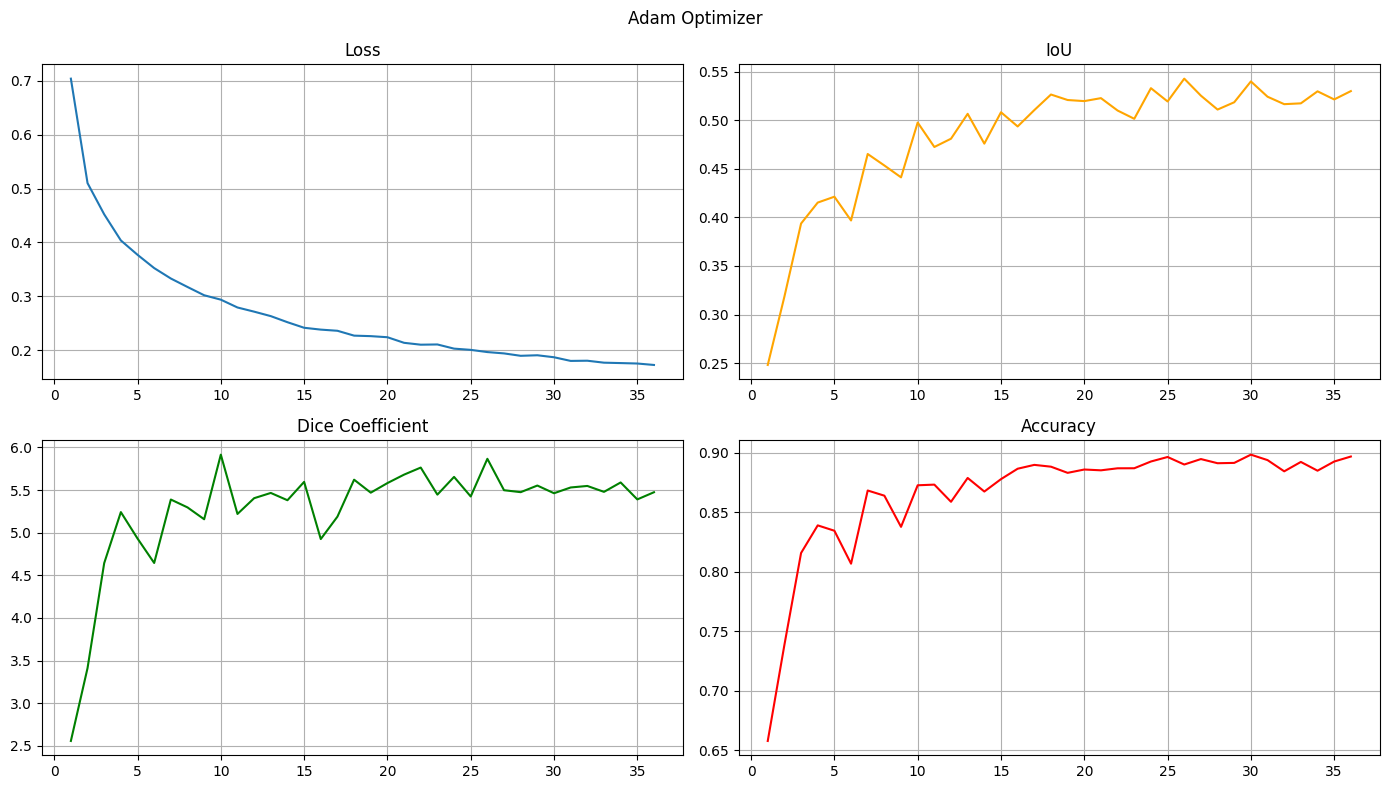

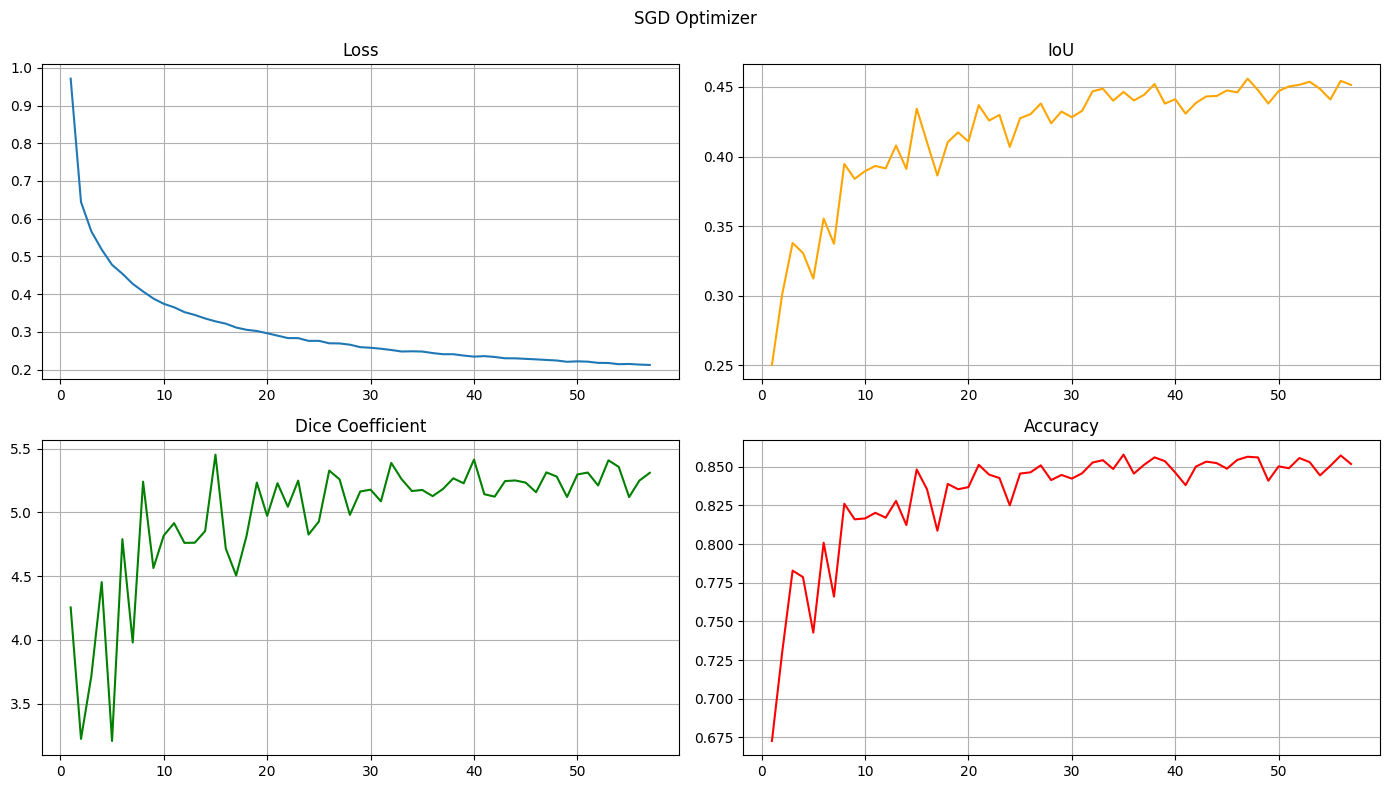

In [13]:
def plot_training_history(history, title='Training History'):
    def to_numpy_list(tensor_list):
        return [t.item() if torch.is_tensor(t) else t for t in tensor_list]

    loss = to_numpy_list(history['loss'])
    iou = to_numpy_list(history['iou'])
    dice = to_numpy_list(history['dice'])
    acc = to_numpy_list(history['accuracy'])
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss, label='Loss')
    plt.title('Loss')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(epochs, iou, label='IoU', color='orange')
    plt.title('IoU')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(epochs, dice, label='Dice', color='green')
    plt.title('Dice Coefficient')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(epochs, acc, label='Accuracy', color='red')
    plt.title('Accuracy')
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_training_history(adam_history, title='Adam Optimizer')
plot_training_history(sgd_history, title='SGD Optimizer')



adam:

Test IoU: 0.3846 | Dice: 5.2336 | Accuracy: 82.92%


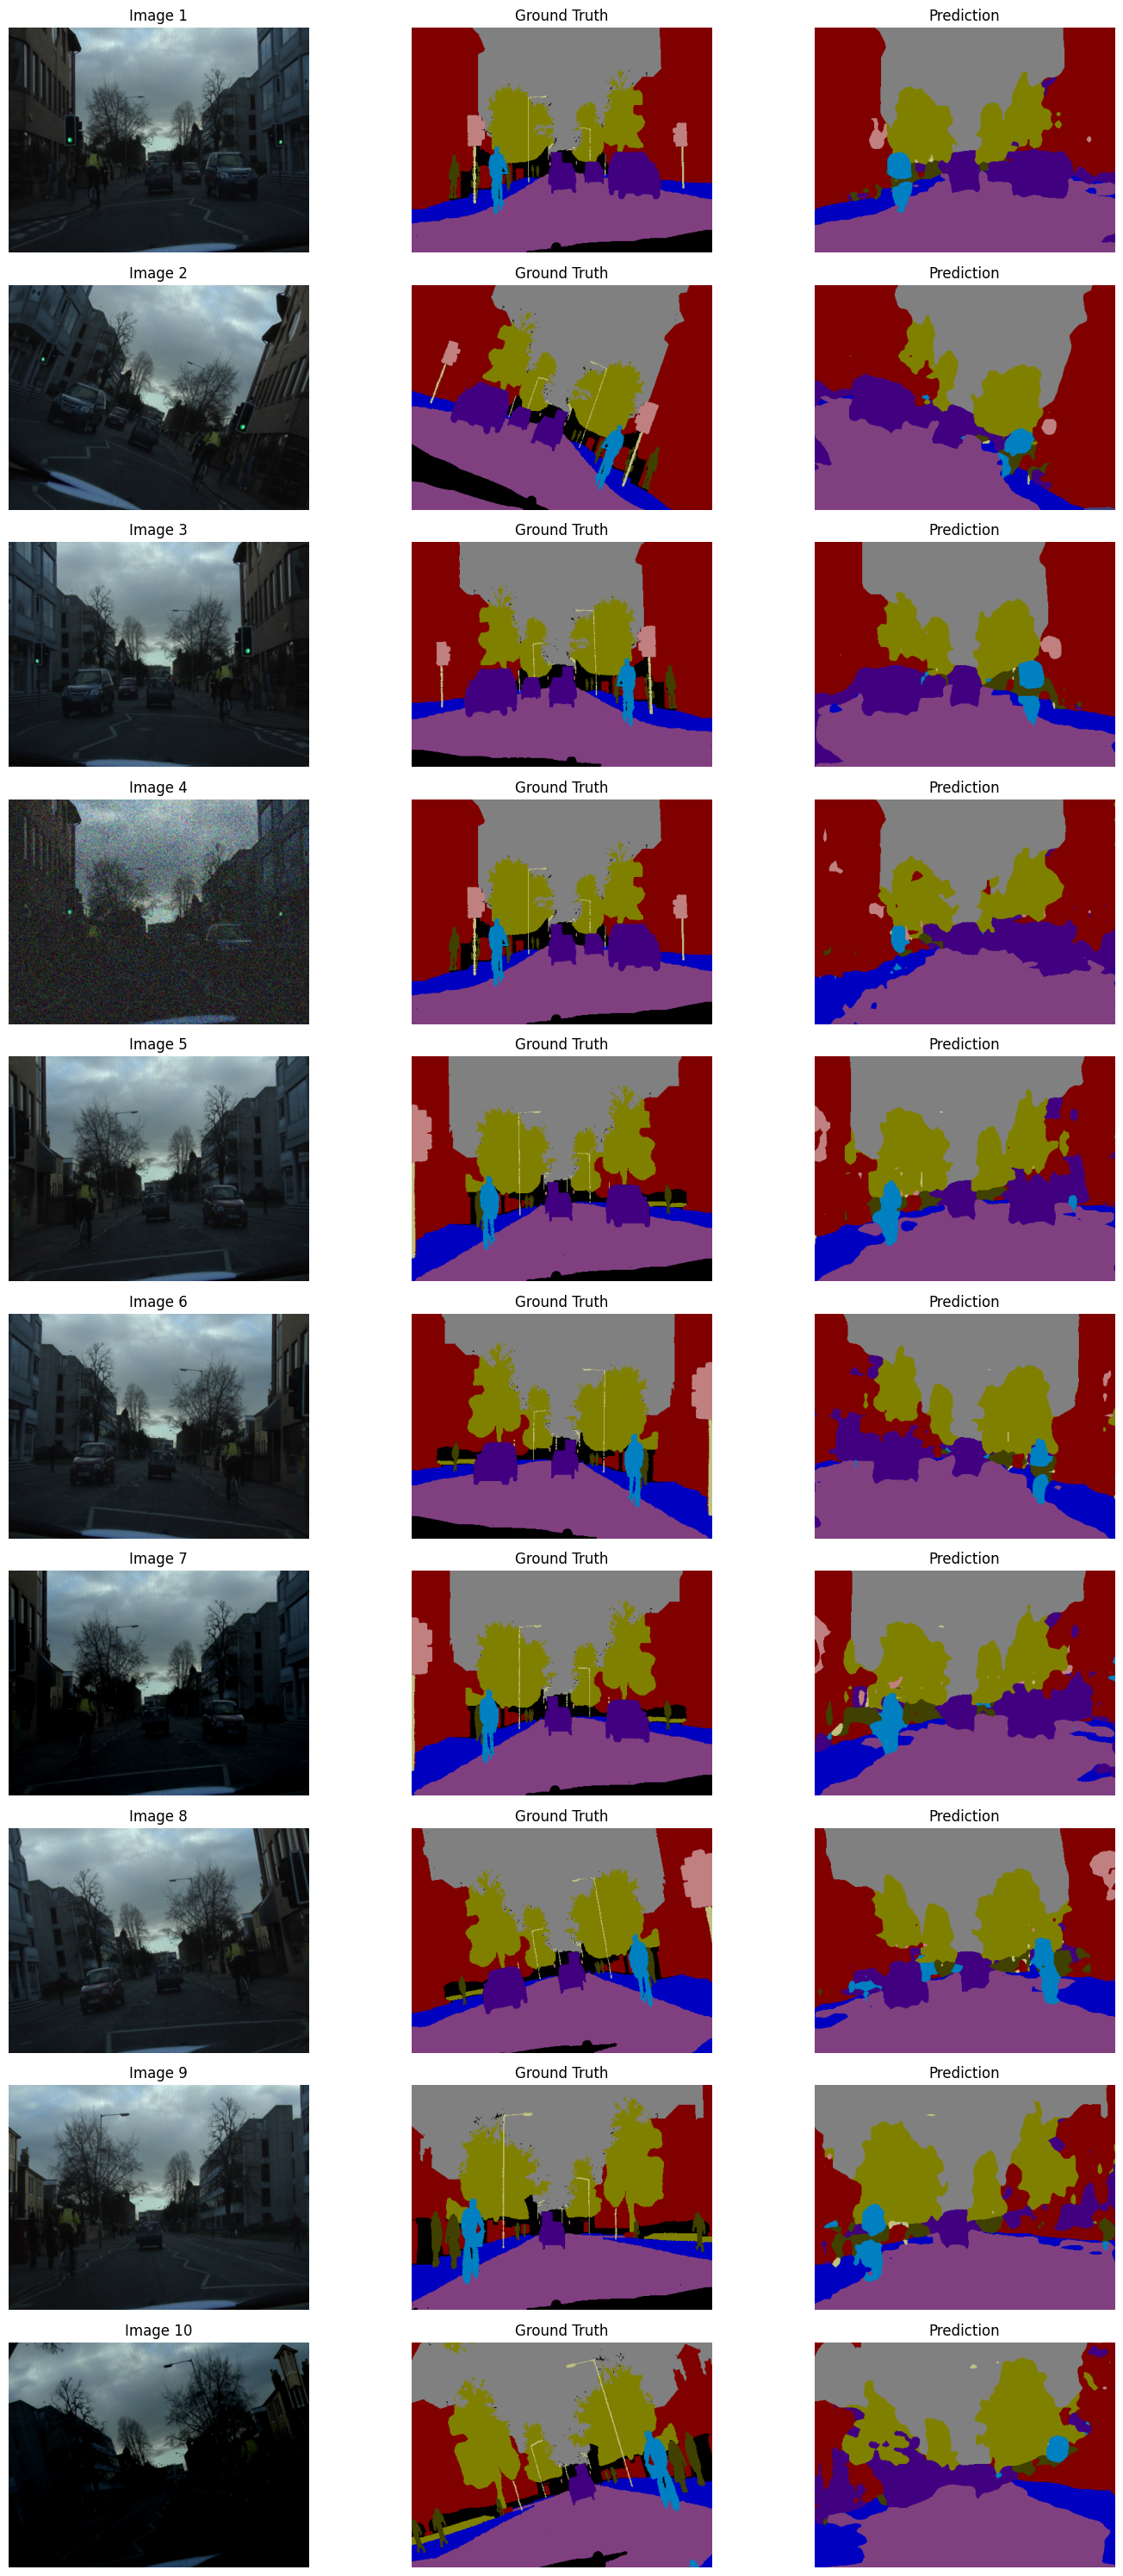


sgd:

Test IoU: 0.3396 | Dice: 4.7684 | Accuracy: 79.35%


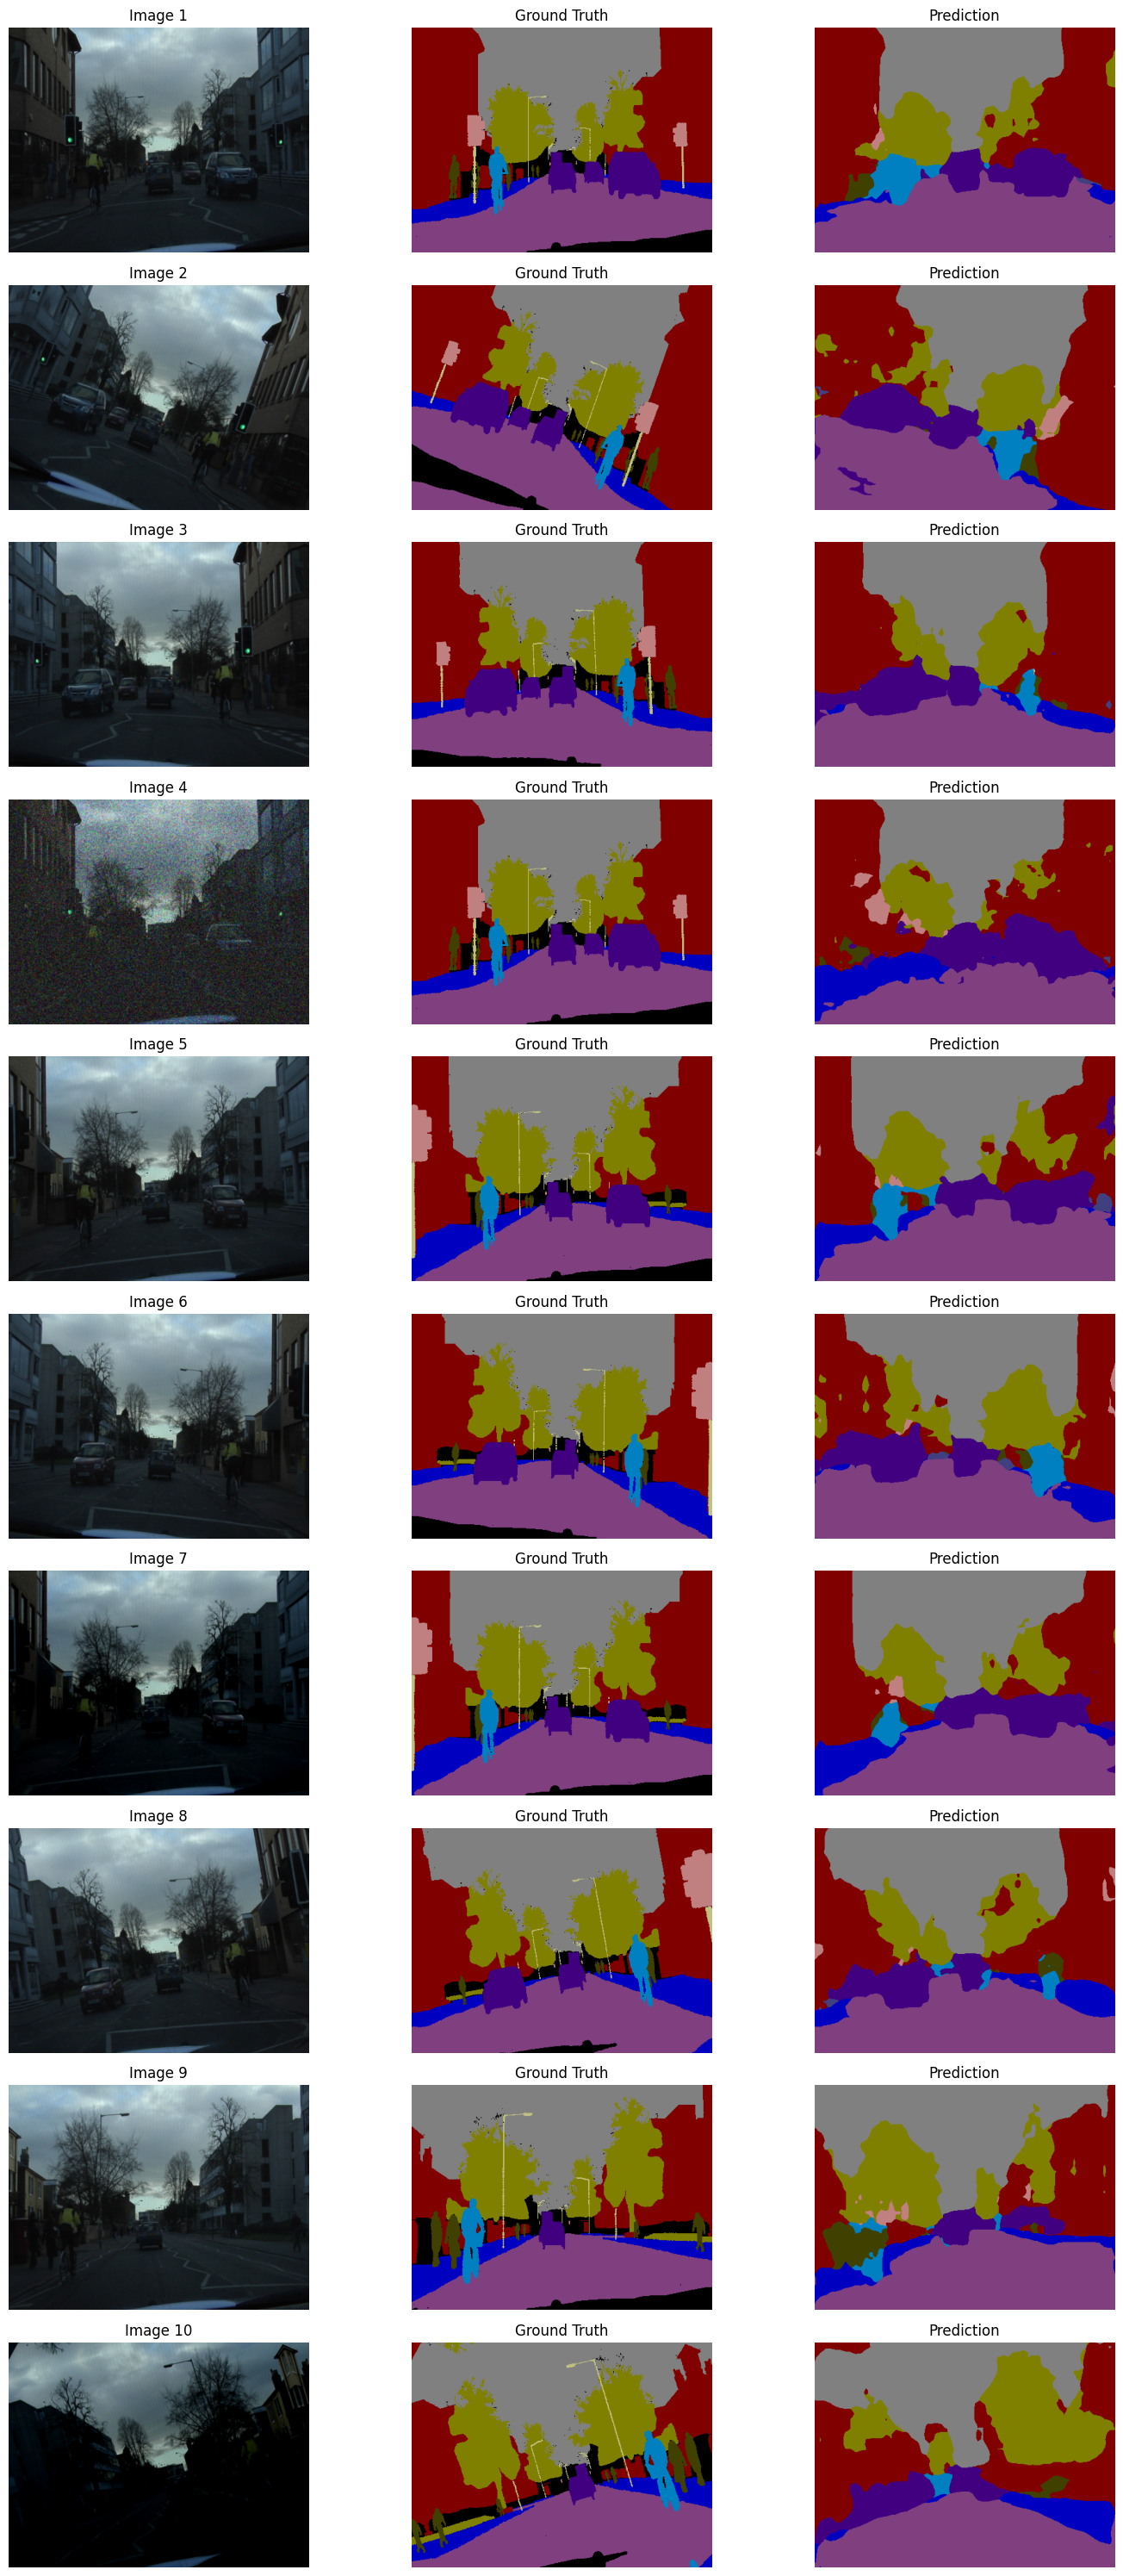

In [14]:
def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    total_iou, total_dice = 0.0, 0.0
    correct_pixels, total_pixels = 0, 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.squeeze(1).long().to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            total_iou += iou_score(preds, masks, num_classes)
            total_dice += dice_coefficient(preds.float(), masks.float())

            valid = (masks != 255)
            correct_pixels += ((preds == masks) & valid).sum().item()
            total_pixels += valid.sum().item()

    avg_iou = total_iou / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    accuracy = correct_pixels / total_pixels if total_pixels > 0 else 0

    print(f"Test IoU: {avg_iou:.4f} | Dice: {avg_dice:.4f} | Accuracy: {accuracy * 100:.2f}%")


CAMVID_CLASS_COLORS = [
    (128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128),
    (0, 0, 192), (128, 128, 0), (192, 128, 128), (64, 64, 128),
    (64, 0, 128), (64, 64, 0), (0, 128, 192), (0, 0, 0)
]

def decode_segmap(label_mask, num_classes=11):
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3), dtype=np.uint8)
    for label in range(num_classes):
        rgb[label_mask == label] = CAMVID_CLASS_COLORS[label]
    rgb[label_mask == 255] = (0, 0, 0)  # Void class
    return rgb

def visualize_samples(model, dataset, device, num_samples=10):
    model.eval()

    plt.figure(figsize=(15, num_samples * 3))

    for idx in range(num_samples):
        image, mask = dataset[idx]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_input)
            pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        image_np = image.permute(1, 2, 0).cpu().numpy()
        gt_mask_np = mask.squeeze().cpu().numpy()
        gt_rgb = decode_segmap(gt_mask_np)
        pred_rgb = decode_segmap(pred)


        plt.subplot(num_samples, 3, idx * 3 + 1)
        plt.imshow(image_np)
        plt.title(f"Image {idx+1}")
        plt.axis('off')

        plt.subplot(num_samples, 3, idx * 3 + 2)
        plt.imshow(gt_rgb)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_samples, 3, idx * 3 + 3)
        plt.imshow(pred_rgb)
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


print(f"\nadam:\n")
model_adam = FastSCNN(num_classes=11)
model_adam.load_state_dict(torch.load('/content/drive/MyDrive/best_model_adam.pth'))
model_adam.to(device)

evaluate_model(model_adam, test_loader, device, num_classes=11)
visualize_samples(model_adam, test_dataset, device, num_samples=10)

print(f"\nsgd:\n")
model_sgd = FastSCNN(num_classes=11)
model_sgd.load_state_dict(torch.load('/content/drive/MyDrive/best_model_sgd.pth'))
model_sgd.to(device)

evaluate_model(model_sgd, test_loader, device, num_classes=11)
visualize_samples(model_sgd, test_dataset, device, num_samples=10)
